In [2]:
import pandas as pd
import seaborn as sns
# from sklearn.model_selection import train_test_split, cross_val_score

from skrules import SkopeRules # in skope_rules.py, from sklearn.externals import six must be changed with import six. Also there, you have to change from collections import Counter, Iterable must be changed
# with from collections import Counter and from collections.abc import Iterable

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import joblib
import matplotlib.pyplot as plt
import os
from os.path import exists

from utilsData import *
from SkopeAlgorithm import *
from UtilsModel import *

import warnings as w
w.filterwarnings('ignore')

First, you have to run getdataset.py, in order to run the following code and other scripts.

```
python getdataset.py
```

In [3]:
data_path = "simulationVictor/"
datafilename = "dataset.csv"

res_path = "simulationVictor/skope/"
if not exists(res_path):
    os.mkdir(res_path)
    
output = "output"

# Train, test, calibration loading

In [4]:
# Verifica si el archivo existe en la carpeta
if os.path.exists(os.path.join(data_path, "train.csv")):
    print("Train.csv exists")
else:
    data = pd.read_csv(data_path+datafilename)
    n_tr = 4000
    n_ts = 1000
    n_c = 5000
    split_dataset(data.iloc[:,0:3].values,data.iloc[:,3].values,n_tr,n_ts,n_c,save_path=data_path)


Split Done


In [5]:
train = pd.read_csv(data_path+"train.csv")
train[output] = train[output].apply(lambda x: 1 if x > 0 else x)
y_train = train[output]
X_train = train.drop([output],axis = 1)

calib = pd.read_csv(data_path+"calib.csv")
calib[output] = calib[output].apply(lambda x: 1 if x > 0 else x)
y_cal = calib[output]
X_cal = calib.drop(["output"],axis = 1)

test = pd.read_csv(data_path+"test.csv")
test[output] = test[output].apply(lambda x: 1 if x > 0 else x)
y_test = test[output]
X_test = test.drop([output],axis = 1)


# Skope Rules for output = 1 (collision class)

In [6]:
param_grid = [{"n_estimators":[10,50,100],"max_depth_duplication":[2,3,5,7], "precision_min":[0.5, 0.6,0.7,0.8,0.9]}]# list of dicts with different parameters (chosen between SkopeRules ones)


bestmodel = OptimizedSkopeRules(X_train, y_train, param_grid, cvmetric="f1", save_rules = True, rules_path = res_path+"skope_rules_collisions.csv", save_model = True, save_path = res_path+"skope_best_collisions.sav")


Time spent for Randomized Search:  110.65966606140137  s
0.6299596491845885 {'precision_min': 0.9, 'n_estimators': 10, 'max_depth_duplication': 3}
0.6982972910588071 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 2}
0.6982972910588071 {'precision_min': 0.8, 'n_estimators': 100, 'max_depth_duplication': 2}
0.719335447609778 {'precision_min': 0.9, 'n_estimators': 100, 'max_depth_duplication': 3}
0.7223713086343992 {'precision_min': 0.7, 'n_estimators': 50, 'max_depth_duplication': 2}
0.7540580068437699 {'precision_min': 0.6, 'n_estimators': 100, 'max_depth_duplication': 5}
0.7307557460581282 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 3}
0.7126649079186576 {'precision_min': 0.5, 'n_estimators': 10, 'max_depth_duplication': 5}
0.7540580068437699 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 5}
0.7540580068437699 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 7}
SkopeRules best parameters with Rando

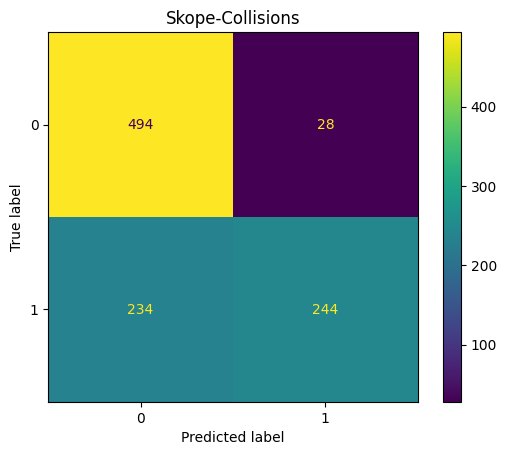

ACC = 0.738, F1 = 0.6506666666666666, PPV = 0.8970588235294118, NPV = 0.6785714285714286, TPR = 0.5104602510460251, TNR = 0.946360153256705

TP = 244, FP = 28, TN = 494, FN = 234


In [7]:
EvaluateModel(bestmodel, X_test, y_test, "Skope-Collisions")


# Skope rules for output = 0 (non collision)

Swap labels to denote non collisions with 1


In [8]:
y_train = 1-y_train
y_test = 1-y_test
y_cal = 1- y_cal

In [9]:
# parameters optimization with RandomizedCV

param_grid = [{"n_estimators":[10,50,100],"max_depth_duplication":[2,3,5,7], "precision_min":[0.5, 0.6,0.7,0.8,0.9]}]# list of dicts with different parameters (chosen between SkopeRules ones)


bestmodel = OptimizedSkopeRules(X_train, y_train, param_grid, cvmetric="f1", save_rules = True, rules_path = res_path+"skope_rules_noncollisions.csv", save_model = True, save_path = res_path+"skope_best_noncollisions.sav")


Time spent for Randomized Search:  107.42993903160095  s
0.7312642021796022 {'precision_min': 0.9, 'n_estimators': 10, 'max_depth_duplication': 3}
0.797527784000223 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 2}
0.7051122891750217 {'precision_min': 0.8, 'n_estimators': 100, 'max_depth_duplication': 2}
0.7393217127738825 {'precision_min': 0.9, 'n_estimators': 100, 'max_depth_duplication': 3}
0.7971169681139187 {'precision_min': 0.7, 'n_estimators': 50, 'max_depth_duplication': 2}
0.8450375581254954 {'precision_min': 0.6, 'n_estimators': 100, 'max_depth_duplication': 5}
0.8223373790749768 {'precision_min': 0.7, 'n_estimators': 100, 'max_depth_duplication': 3}
0.8535199680421701 {'precision_min': 0.5, 'n_estimators': 10, 'max_depth_duplication': 5}
0.8450375581254954 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 5}
0.8450375581254954 {'precision_min': 0.5, 'n_estimators': 100, 'max_depth_duplication': 7}
SkopeRules best parameters with Rando

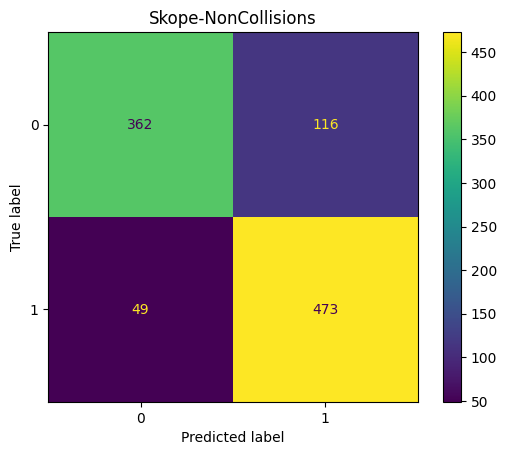

ACC = 0.835, F1 = 0.8514851485148515, PPV = 0.8030560271646859, NPV = 0.8807785888077859, TPR = 0.9061302681992337, TNR = 0.7573221757322176

TP = 473, FP = 116, TN = 362, FN = 49


In [10]:
EvaluateModel(bestmodel, X_test, y_test, "Skope-NonCollisions")